In [20]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","RColorBrewer","zoo","lubridate","tidyverse",
              "ggpubr")
for(x in libraries) {library(x, character.only=TRUE, warn.conflicts=FALSE, quietly=TRUE)}

'%&%' = function(x,y)paste0(x,y)

theme_set(theme_bw())
version$version.string

options(scipen=10000)
Sys.setlocale("LC_ALL","Korean")

[1] "R version 4.2.2 (2022-10-31)"

Warning message in Sys.setlocale("LC_ALL", "Korean"):
“OS reports request to set locale to "Korean" cannot be honored”


[1] ""

In [21]:
time_0 <- as.Date("2022-05-01") ## the date of symptom onset of the initial case in the UK
time_start <- as.Date("2022-04-15") ## the start date for the 14-days moving average
time_end <- as.Date("2023-01-27") ## the end date of study period

In [22]:
#### incidence data (retrieved from the OWiD)
read.csv("../data/incidence_OWiD/owid-monkeypox-data.csv") %>% rename(country=location) %>% 
mutate(date=as.Date(date)) %>% filter(date >= time_start) %>% filter(country!=c("World")) %>%
dplyr::select(country, iso_code, date, new_cases) -> df_inci_raw

#### classifying China data into Taiwan, Hong Kong, mainland China
df_inci_raw %>% 
mutate(iso_code=case_when(iso_code==c("CHN") & date < as.Date("2022-09-06") ~ c("TWN"),
                          iso_code==c("CHN") & date == as.Date("2022-10-09") ~ c("TWN"),
                          iso_code==c("CHN") & date == as.Date("2022-09-06") ~ c("HKG"), TRUE ~ iso_code),
       country=case_when(iso_code==c("TWN") ~ c("Taiwan, Province of China"), 
                         iso_code==c("HKG") ~ c("Hong Kong"), TRUE ~ country)) -> df_inci

In [23]:
#### adding dates with zero case and calculating the cumulative number of cases
as.data.frame(seq(time_start, time_end, by="day")) -> temp_cal; colnames(temp_cal) <- c("date") 
unique(df_inci$country) -> MPX_country_list
df_inci$date <- as.Date(df_inci$date); temp_cal$date <- as.Date(temp_cal$date); 

df_inci_list <- list()
for(i in 1:length(MPX_country_list)){
    df_inci %>% filter(country==MPX_country_list[i]) -> temp_inci
    merge(temp_cal, temp_inci, by=c("date"), all.x=TRUE) -> temp_inci_all
    
    temp_inci_all$country[is.na(temp_inci_all$country)] <- unique(temp_inci$country)
    temp_inci_all$location[is.na(temp_inci_all$location)] <- unique(temp_inci$location)
    temp_inci_all$iso_code[is.na(temp_inci_all$iso_code)] <- unique(temp_inci$iso_code)
    temp_inci_all$new_cases[is.na(temp_inci_all$new_cases)] <- 0

    temp_inci_all %>% dplyr::select(country, iso_code, date, new_cases) %>%
    group_by(country) %>% mutate(total_cases=cumsum(new_cases)) -> df_inci_list[[i]]    
}

do.call("rbind", df_inci_list) %>% as.data.frame() %>% arrange(country, date) -> df_inci

In [24]:
#### merging the MSM population size
## MSM population
read.csv("../data/MSM_pop/df_MSM_UNAIDS.csv") %>% rename(country=location) -> df_MSM1
read.csv("../data/MSM_pop/df_full_list_MSMsize.csv") %>% rename(country=location) -> df_MSM2

## revising the pop2022 column from df_MSM2
read.csv("../data/MSM_pop/df_pop_raw.csv") %>% dplyr::select(cca2, pop2022) %>% rename(iso_2=cca2) -> df_pop1
read.csv("../data/MSM_pop/df_region.csv") %>% dplyr::select(alpha.2,alpha.3, name) %>%
rename(iso_2=alpha.2, iso_code=alpha.3, country=name) -> df_pop2
merge(df_pop1, df_pop2, by=c("iso_2")) -> df_pop
merge(df_MSM2 %>% dplyr::select(-pop2022), 
      df_pop %>% dplyr::select(iso_code, pop2022), by=c("iso_code"), all.x=TRUE) -> df_MSM2

## giving a priority to UNAIDS dashboard
merge(df_MSM1, df_MSM2, by=c("country"),all=TRUE) %>% 
dplyr::select(country, iso_code, estimate, MSM_size, region, sub_region, pop2022) %>%
mutate(prop=estimate/pop2022) %>%
mutate(imputed=case_when(!is.na(estimate) ~ estimate, is.na(estimate) & !is.na(MSM_size) ~ MSM_size), 
       prop=imputed/pop2022) -> temp

## imputation of missing values
temp %>% group_by(sub_region) %>% drop_na(imputed) %>% summarise(prop_avg = mean(prop)) -> prop_avg
merge(temp, prop_avg, by=c("sub_region"), all.x=TRUE) %>% drop_na(pop2022) %>%
mutate(censored=case_when(!is.na(prop)~0, is.na(prop)~1),
       prop=case_when(!is.na(prop)~prop, is.na(prop)~prop_avg),
       imputed=case_when(!is.na(imputed)~imputed, is.na(imputed)~prop*pop2022)) -> df_MSM_imputed

## modifying Samoa data with the value from UNAIDS reports
df_MSM_imputed %>% mutate(imputed=case_when(country==c("Samoa")~MSM_size, TRUE~imputed),
                          prop=case_when(country==c("Samoa")~MSM_size/pop2022, TRUE~prop)) -> df_MSM_imputed

## checking which country have NAs in the MSM population size
df_MSM_imputed %>% filter(region==c("Asia")) %>% filter(censored==1) -> temp; unique(temp$country)

## merging incidence data with MSM population data
merge(df_inci, df_MSM_imputed %>% dplyr::select(iso_code, imputed, pop2022, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) -> df_all_inci
write.csv(df_all_inci, "../data/MSM_pop/df_all_inci_WHO_backproj.csv")

[1] "Macao"                                  
[2] "Korea (Democratic People's Republic of)"
[3] "Korea, Republic of"                     
[4] "Taiwan, Province of China"              
[5] "Brunei Darussalam"                      
[6] "Iran (Islamic Republic of)"             
[7] "Palestine, State of"

In [25]:
#### applying a 14-day moving average for the newly reported and cumulative case counts
df_all_inci %>% group_by(country) %>% arrange(date) %>%
mutate(MA_new_cases = zoo::rollmean(new_cases, k=14, align="right", fill=NA),
       MA_total_cases = zoo::rollmean(total_cases, k=14, align="right", fill=NA)) -> temp
temp$MA_new_cases[is.na(temp$MA_new_cases)]<-0; temp$MA_total_cases[is.na(temp$MA_total_cases)]<-0; 

temp %<>% mutate(MA_new_cases=case_when(MA_new_cases<0 ~ 0, TRUE ~ MA_new_cases),
                 MA_total_cases=case_when(MA_total_cases<0 ~ 0, TRUE ~ MA_total_cases))

#### calculating the cumlative incidence proportion (i.e., cumulative incidecne/MSM population)
temp %>% rename(MSM_pop=imputed) %>% mutate(MSM_pop=MSM_pop*1000) %>% 
group_by(country) %>% mutate(cum_icni_prop=MA_total_cases/(MSM_pop)) %>%
dplyr::select(iso_code, country, region, sub_region, date, new_cases, total_cases, MA_new_cases, MA_total_cases,
              MSM_pop, pop2022, cum_icni_prop) %>%
filter(date >= time_0) -> df_inci_MA

#### defining 6 regions
df_inci_MA %<>% ungroup() %>%
mutate(region = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), TRUE~region)) %>%
arrange(country, date)

write.csv(df_inci_MA, "../data/incidence_OWiD/df_inci_OWiD.csv")

`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.


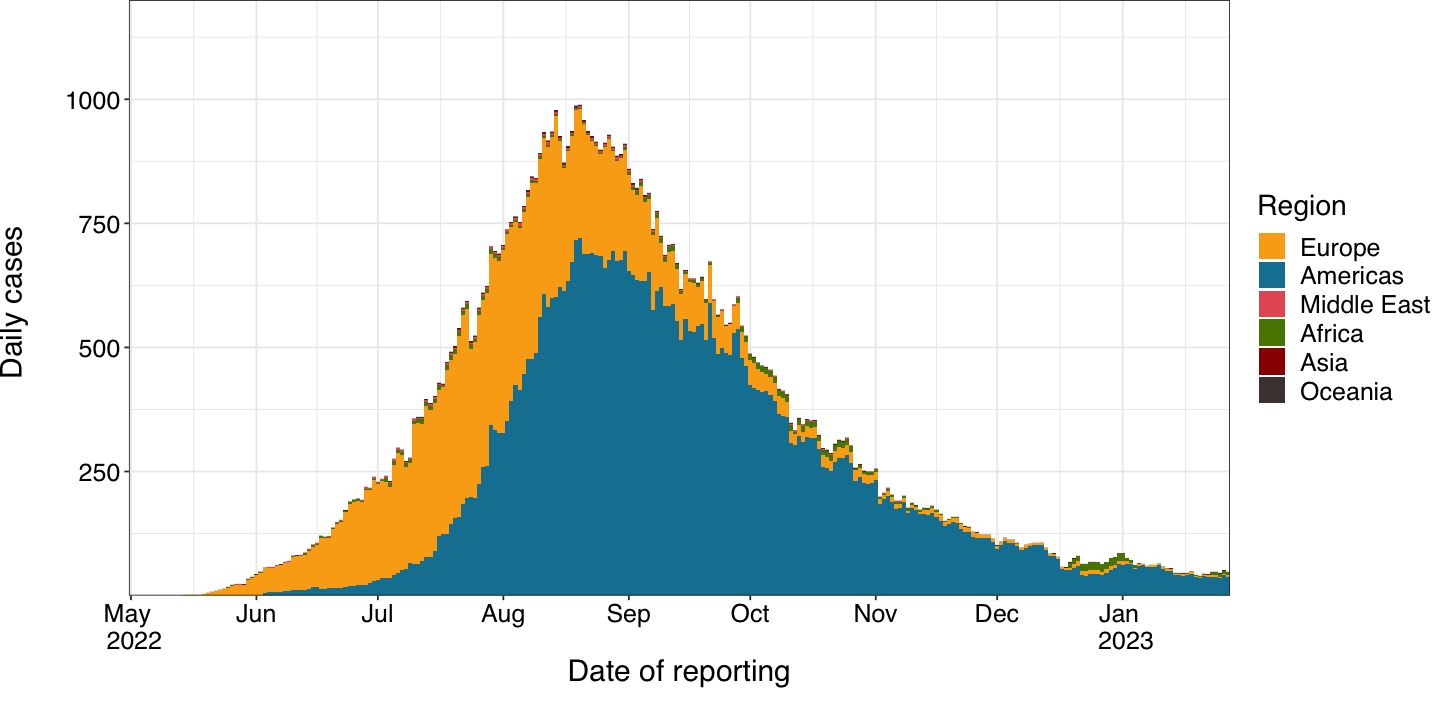

In [26]:
#### number of the confirmed case by region
df_inci_MA %>% group_by(region, date) %>% summarize(region_inci=sum(MA_new_cases)) %>% ungroup() -> df_inci_region
df_inci_region$region <- factor(df_inci_region$region, 
                                levels=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"))

options(repr.plot.width=12,repr.plot.height=6)
ggplot(df_inci_region, aes(x = date, y=region_inci, fill = fct_reorder(region, region_inci))) +
geom_bar(stat="identity", width=1) +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=20, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15)) +
xlab("Date of reporting") +
ylab("Daily cases \n") +
# ggtitle("Number of the confirmed mpox case by region (with a 14-day moving average)") +
scale_x_date(date_breaks = "1 months", expand = c(0, 0),
             labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                          paste(month(x, label = TRUE), "\n", year(x)), 
                                          paste(month(x, label = TRUE)))) +
scale_y_continuous(expand = c(0, 0), breaks=c(250,500,750,1000)) +
coord_cartesian(ylim = c(0,1200)) +
theme(plot.margin = margin(0, 0, 0.7, 0, "cm")) -> fig_region
             
             fig_region

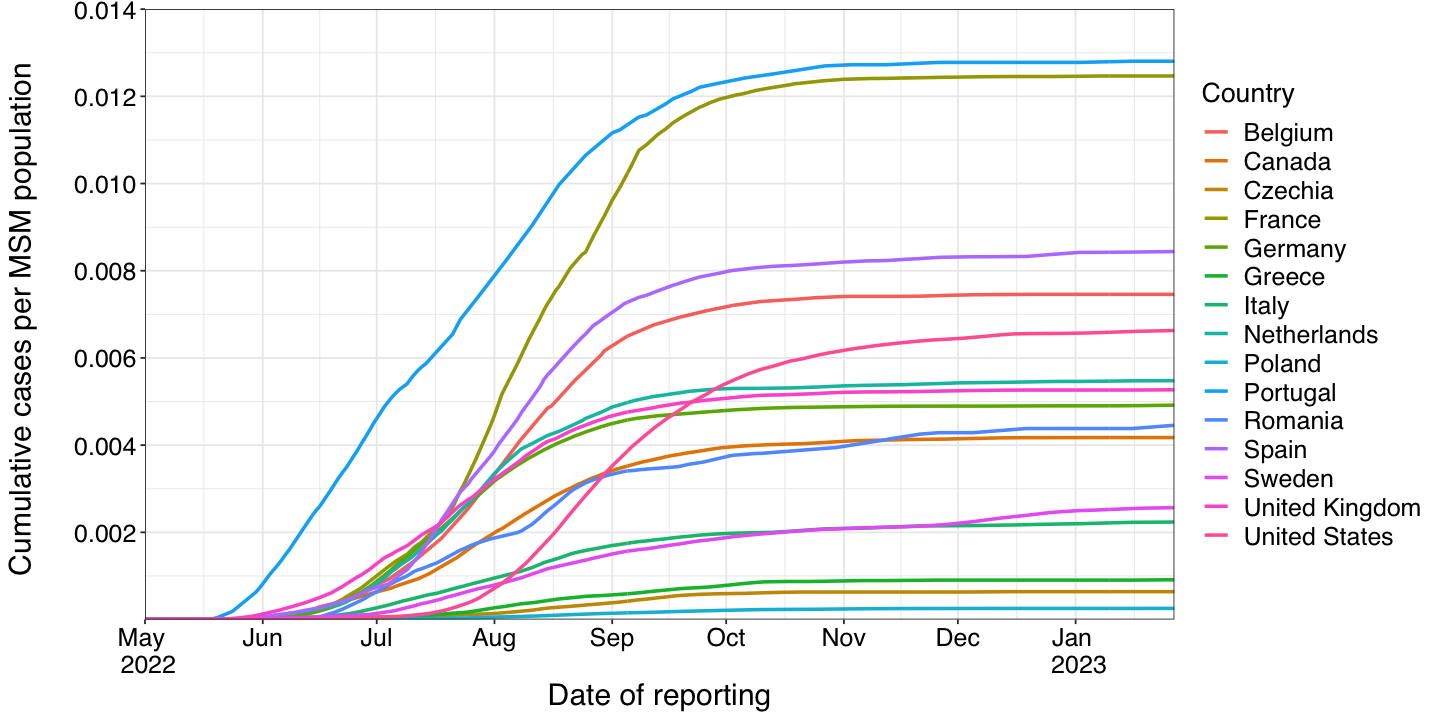

In [27]:
#### cumulative case counts by MSM population by region
df_inci_MA %>% filter(sub_region %in% c('Western Europe','Northern America','Northern Europe',
                                        'Southern Europe','Eastern Europe')) %>% filter(pop2022 >= 10000) %>% 
filter(!(country %in% c("Ukraine", "Russia"))) %>% rename(Country=country) -> df_final

options(repr.plot.width=12,repr.plot.height=6)
library(RColorBrewer)
getPalette = colorRampPalette(brewer.pal(9, "Set1"))
colourCount <- length(unique(df_final$Country))

ggplot(df_final, aes(x = date, y=cum_icni_prop, colour = Country)) +
geom_line(linewidth=1) +
scale_fill_manual("Country", values = getPalette(colourCount)) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=20, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      legend.title = element_text(size = 16),
      legend.text = element_text(size = 15)) +

xlab("Date of reporting") +
ylab("Cumulative cases per MSM population \n") +
# ggtitle("Cumulative cases per MSM population in Europe and Northern America") +
scale_x_date(date_breaks = "1 months", expand = c(0, 0),
             labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                          paste(month(x, label = TRUE), "\n", year(x)), 
                                          paste(month(x, label = TRUE)))) +
scale_y_continuous(expand = c(0, 0), breaks=c(0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014)) +
coord_cartesian(ylim = c(0,0.014)) -> fig_final
             
fig_final

ERROR: Error: cannot open stream ../figures/FigS1.svg


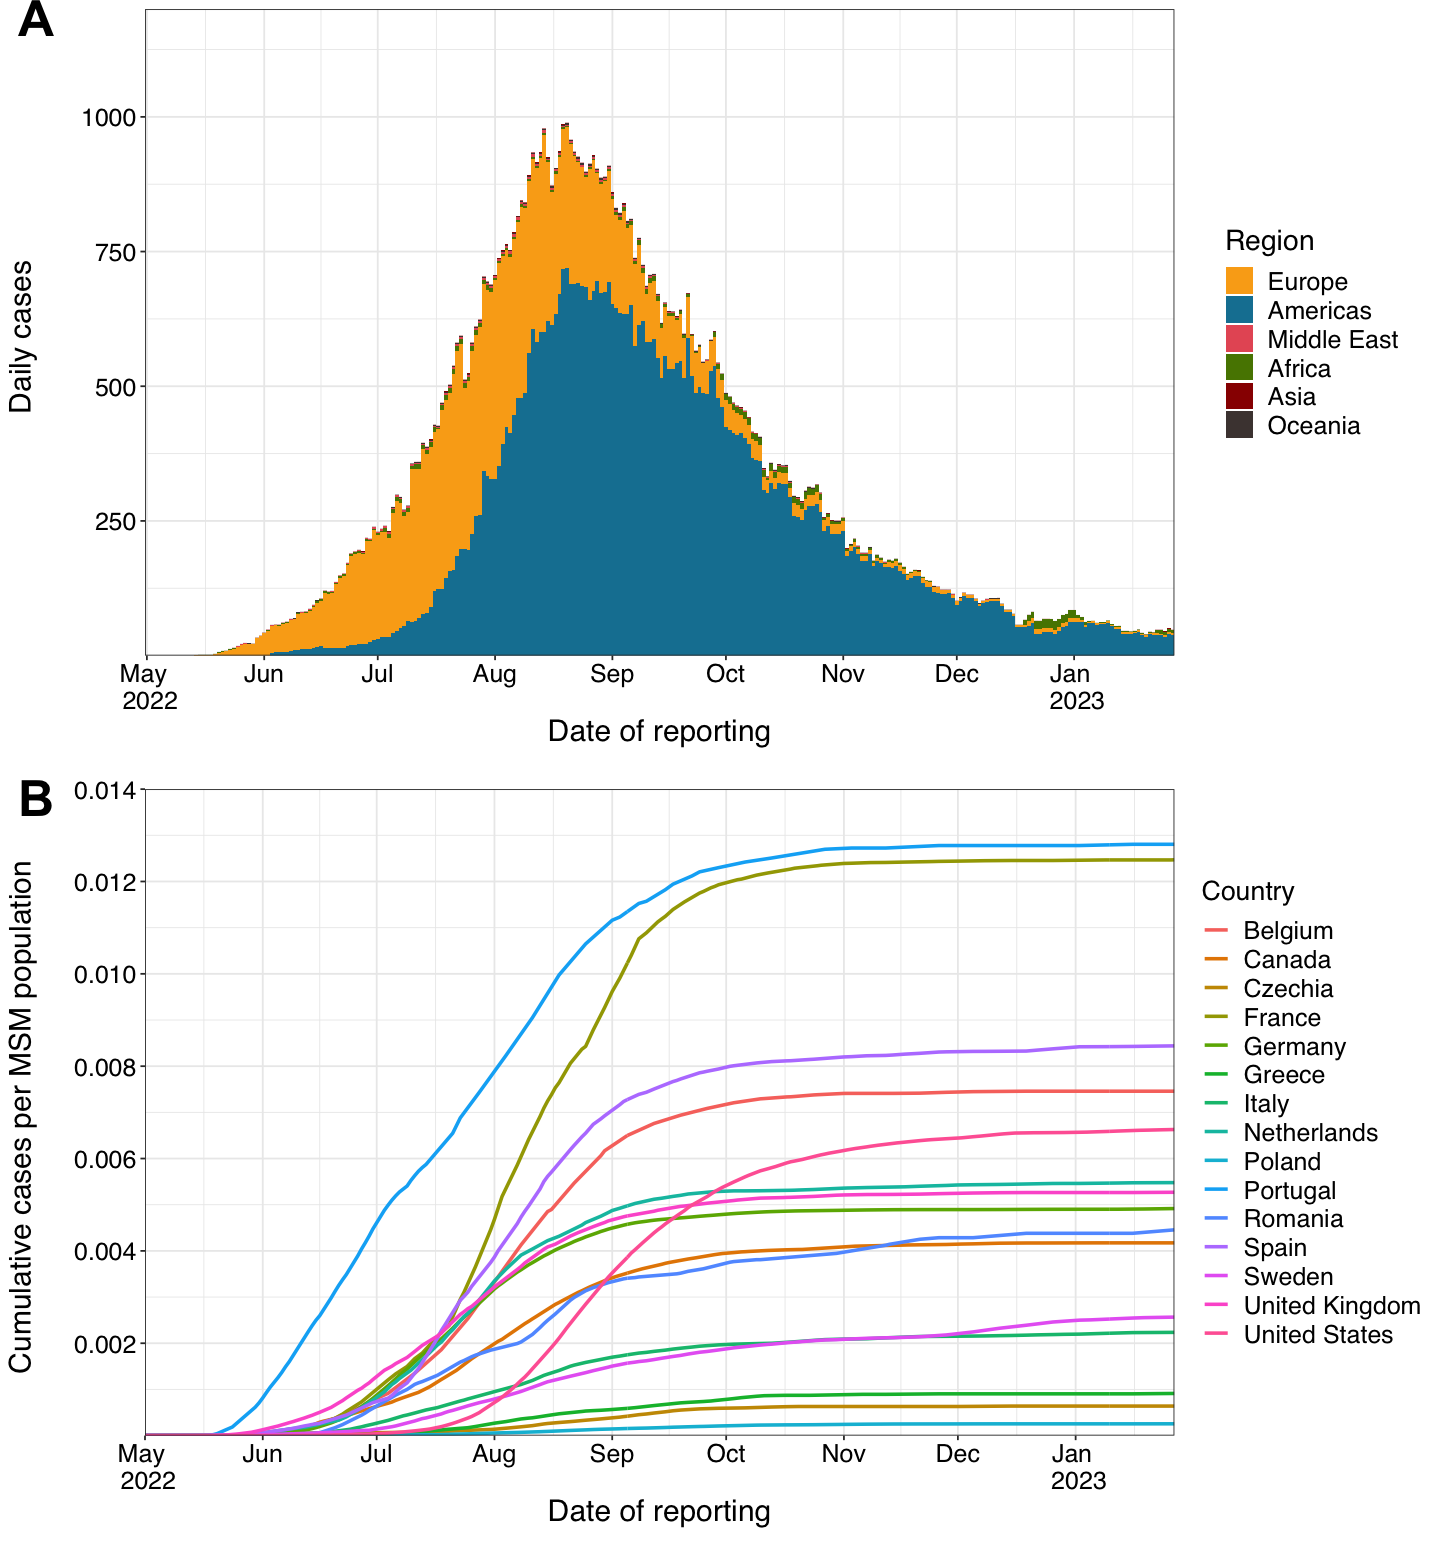

In [28]:
library(ggpubr)
options(repr.plot.width=12,repr.plot.height=13)
ggarrange(fig_region, fig_final, ncol = 1, align = "hv", 
          labels = c("A", "B"), font.label = list(size = 30), vjust=1)

ggsave("../figures/FigS1.svg", width = 12, height = 12, dpi=600)

In [ ]:
#### number of the confirmed case in Japan
read.csv("../data/incidence_JPN/mpox_Japan_linelist.csv") %>%
dplyr::select(Age, Sex, Date.of.reporting.from.MHLW, Date.of.medical.attendance, 
              Travel.history, Contact.history) %>%
rename(Reporting=Date.of.reporting.from.MHLW, Visiting=Date.of.medical.attendance) -> df_JPN
df_JPN$Reporting <- as.Date(df_JPN$Reporting); df_JPN$Visiting <- as.Date(df_JPN$Visiting)

library(ggpattern)
options(repr.plot.width=12,repr.plot.height=6)
df_JPN %<>% 
mutate(imported=case_when(Travel.history==c("None")~c("No travel history"), TRUE~c("Travelled abroad")),
       contact=case_when(Contact.history!=c("Not available")~c("With an individual from abroad"),
                         TRUE~c("Not available")))

df_JPN$imported <- factor(df_JPN$imported, levels=c("Travelled abroad", "No travel history"))

df_JPN %>% ggplot(aes(x = Visiting, fill = imported, pattern = contact)) +
# geom_histogram(aes(x = Visiting, fill = imported), postion="identity") +
geom_bar_pattern(colour = "black", pattern_fill = "black", width = 1,
pattern_angle = 45, pattern_density = 0.1, pattern_spacing = 0.025, pattern_key_scale_factor = 0.6, 
stat = "count", position = "stack") +
scale_fill_manual("Travel history", 
                  limits=c("Travelled abroad", "No travel history"), values = c("#FAAB18", "#3dbae0")) +
scale_pattern_manual("Contact history", 
                     values = c("With an individual from abroad" = "stripe", "Not available" = "none")) +

theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=20, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.minor = element_blank(),
      legend.title = element_text(size = 16),
      legend.text = element_text(size = 15),
      legend.position = c(0.32, .97),
      legend.justification = c("right", "top"), legend.box.just = "left", legend.margin = margin(2, 2, 2, 2)) +
xlab("Date of medical attendance") +
ylab("Daily cases \n") +
scale_x_date(date_breaks = "1 months", expand = c(0, 0), 
             limits=c(as.Date("2022-07-23"), as.Date("2023-02-02")),
             labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                          paste(month(x, label = TRUE), "\n", year(x)), 
                                          paste(month(x, label = TRUE)))) +
scale_y_continuous(expand = c(0, 0), breaks=c(1,2,3,4)) +
coord_cartesian(ylim = c(0,4)) +
guides(pattern = guide_legend(override.aes = list(fill = "white")),
fill = guide_legend(override.aes = list(pattern = "none"))) +
theme(plot.margin = margin(0.2, 0.3, 0, 0, "cm")) -> figure_JPN

figure_JPN
ggsave("../figures/Fig1_1.svg", width = 12, height = 6, dpi=600)

In [ ]:
library(assertthat); library(purrr); library(igraph); library(ggraph); library(ggmap)

In [39]:
read.csv("../../MonkeypoxResearchAsia/data/flight/flight_matrix.csv") %>% dplyr::select(destination, Japan) %>%
mutate(Japan=case_when(Japan < 4500*52 ~ 100*52, 
                       Japan >= 4500*52 & Japan < 30000*52 ~ 10000*52,
                       Japan >= 30000*52 & Japan < 50000*52 ~ 30000*52,
                       TRUE ~ 50000*52)) -> temp
write.csv(temp, "../data/flight/flight_matrix_temp.csv")

In [43]:
read.csv("../../MonkeypoxResearchAsia/data/flight/flight_matrix.csv") %>% dplyr::select(destination, Japan) -> temp
write.csv(temp, "../../MonkeypoxResearchAsia/data/flight/flight_matrix_JPN.csv")


temp %>% mutate(Japan=case_when(Japan < 3000*52 ~ 1000*52,
                                Japan >= 3000*52 & Japan <=10000*52 ~ 10000*52,
                                Japan > 10000*52 & Japan <30000*52 ~ 30000*52,
                                TRUE ~ 50000*52)) -> temp_open
write.csv(temp_open, "../data/flight/flight_matrix_temp.csv")

In [ ]:
#### geographical location of each country
read.csv("../data/geo_info.csv") %>% filter(!is.na(lat)) -> df_geo_info
read.csv("../data/iso2_iso3.csv") %>% dplyr::select(alpha.2, alpha.3) %>% 
rename(iso=alpha.2, iso_3=alpha.3) -> df_iso
merge(df_geo_info, df_iso, by=c("iso"), all=TRUE) %>% filter(!is.na(country)) -> df_geo_info

#### flight volume from Japan
read.csv("../../MonkeypoxResearchAsia/data/flight/flight_matrix_JPN.csv") %>% #dplyr::select(destination, Japan) %>% 
mutate(destination=case_when(destination==c("Bolivia, Plurinational State of")~c("Bolivia"),
                             destination==c("Brunei Darussalam")~c("Brunei"),
                             destination==c("Cabo Verde")~c("Cape Verde"),
                             destination==c("Eswatini")~c("Swaziland"),
                             destination==c("Hong Kong, China")~c("Hong Kong"),
                             destination==c("Iran, Islamic Republic of")~c("Iran"),
                             destination==c("Korea, Republic of")~c("South Korea"),
                             destination==c("Macao, China")~c("Macau"),
                             destination==c("Lao People\'s Democratic Republic")~c("Laos"),
                             destination==c("Moldova, Republic of")~c("Moldova"),
                             destination==c("Myanmar")~c("Myanmar [Burma]"),
                             destination==c("North Macedonia")~c("Macedonia [FYROM]"),
                             destination==c("Palestine, State of")~c("Palestinian Territories"),
                             destination==c("Saint Vincent and The Grenadines")~c("Saint Vincent and the Grenadines"),
                             destination==c("Russian Federation")~c("Russia"),
                             destination==c("Syrian Arab Republic")~c("Syria"),
                             destination==c("Taiwan, Province of China")~c("Taiwan"),
                             destination==c("Tanzania, United Republic of")~c("Tanzania"),
                             destination==c("United States Virgin Islands")~c("U.S. Virgin Islands"),
                             destination==c("United States of America")~c("United States"),
                             destination==c("Viet Nam")~c("Vietnam"),
                             TRUE~destination)) %>% mutate(Japan=Japan/52) -> flight_JPN

merge(df_geo_info, flight_JPN %>% rename(country=destination), by=c("country"), all=TRUE) %>%
filter(!is.na(Japan)) %>% filter(!iso_3==c("JPN")) -> flight_JPN

In [ ]:
thres <- 3000

merge(flight_JPN, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region) %>% rename(iso_3=iso_code),
      by=c("iso_3"), all.x=TRUE) %>% 
rename(from=iso_3, weight=Japan, xend=lon, yend=lat) %>%
mutate(to=c("JPY"), x=c(138.2529), y=c(36.20482)) %>% 
mutate(Travel=case_when(region %in% c("Europe", "Americas") ~ c("Europe & Northern America"), 
                        TRUE ~ c("Other regions"))) %>%
dplyr::select(from, to, weight, x, y, xend, yend, Travel) %>% 
filter(weight >= thres) -> edges_for_plot

In [ ]:
df_MSM_imputed %>% filter(iso_code %in% c("USA", "CHN", "IND"))
df_MSM_imputed %>% filter(country %in% c("Guam"))

In [ ]:
# df_MSM_imputed %>% filter(prop >= 0.03)
df_MSM_imputed %>% filter(prop < 0.005)

In [ ]:
options(repr.plot.width=15,repr.plot.height=10)
label_set = c("1 million", "2 million", "3 million")
break_set = c(1000000, 2000000, 3000000)

library(ggnewscale)

flight_JPN %>% filter(Japan >= thres) %>%
ggplot() + 
geom_polygon(aes(x = long, y = lat, group = group),
         data = map_data('world'),
         fill = "#CECECE", color = "#515151", size = 0.15) +

geom_curve(aes(x = x, y = y, xend = xend, yend = yend, color=Travel, size = weight),
           data = edges_for_plot, curvature = 0.33,
           alpha = 0.5) +
scale_color_manual(name=c("Travel destination"), values = c("#F8766D", "#00BFC4")) +
scale_size_continuous("Travel volume", range = c(0.25, 5)) + 

new_scale("size") +

geom_point(data = merge(df_MSM_imputed %>% 
                        mutate(imputed=case_when(iso_code==c("CHN") ~ 3830, 
                                                 iso_code==c("IND") ~ 3500, 
                                                 TRUE ~ imputed)) %>%
                        rename(iso_3=iso_code), df_geo_info, by=c("iso_3"), all.x=TRUE),
           aes(x = lon, y = lat, size = imputed*1000),       
           shape = 21, fill = 'white',
           color = 'black', stroke = 0.5) +
scale_size_continuous("Estimated MSM population size", labels=label_set, breaks=break_set, range = c(1, 25)) +  

geom_text(aes(x = lon, y = lat, label = country),             
          hjust = 0, nudge_x = 1, nudge_y = 4,
          size = 5, color = "white", fontface = "bold") +

coord_quickmap(xlim = c(60, 160),  ylim = c(-35, 80)) +

theme(panel.grid = element_blank()) + theme(axis.text = element_blank()) +
theme(axis.ticks = element_blank()) + theme(axis.title = element_blank()) +
theme(legend.position = "right", legend.title = element_text(size = 15), legend.text = element_text(size = 15)) + 
theme(panel.grid = element_blank()) +
theme(panel.background = element_rect(fill = "#596673")) +
theme(plot.margin = margin(-2, -5, -2, -5, "cm")) +
guides(color = guide_legend(override.aes = list(linewidth = 5))) -> figure_travel

figure_travel

ggsave("../figures/Fig1_2.svg", width = 15, height = 10, dpi=600)

In [ ]:
options(repr.plot.width=15,repr.plot.height=10)
label_set = c("10,000", "30,000", "50,000")
break_set = c(10000, 30000, 50000)

library(ggnewscale)

flight_JPN %>% filter(Japan >= thres) %>%
ggplot() + 
geom_polygon(aes(x = long, y = lat, group = group),
         data = map_data('world'),
         fill = "#CECECE", color = "#515151", size = 0.15) +

geom_curve(aes(x = x, y = y, xend = xend, yend = yend, color=Travel, size = weight),
           data = edges_for_plot, curvature = 0.33,
           alpha = 0.5) +
scale_color_manual(name=c("Travel destination"), values = c("#F8766D", "#00BFC4")) +
scale_size_continuous("Weekly travel volume", labels=label_set, breaks=break_set, range = c(0.25, 5)) + 

geom_text(aes(x = lon, y = lat, label = country),             
          hjust = 0, nudge_x = 1, nudge_y = 4,
          size = 5, color = "white", fontface = "bold") +

coord_quickmap(xlim = c(60, 160),  ylim = c(-35, 80)) +

theme(panel.grid = element_blank()) + theme(axis.text = element_blank()) +
theme(axis.ticks = element_blank()) + theme(axis.title = element_blank()) +
theme(legend.position = "right", legend.title = element_text(size = 15), legend.text = element_text(size = 15)) + 
theme(panel.grid = element_blank()) +
theme(panel.background = element_rect(fill = "#596673")) +
theme(plot.margin = margin(-2, -5, -2, -5, "cm")) +
guides(color = guide_legend(override.aes = list(linewidth = 5)))

ggsave("../figures/Fig1_2_additioanl_legend.svg", width = 15, height = 10, dpi=600)

In [ ]:
options(repr.plot.width=15,repr.plot.height=10)
label_set = c("1 million", "2 million", "over 3 million")
break_set = c(1000000, 2000000, 3000000)

library(ggnewscale)

flight_JPN %>% filter(Japan >= thres) %>%
ggplot() + 
geom_polygon(aes(x = long, y = lat, group = group),
         data = map_data('world'),
         fill = "#CECECE", color = "#515151", size = 0.15) +

geom_curve(aes(x = x, y = y, xend = xend, yend = yend, color=Travel, size = weight),
           data = edges_for_plot, curvature = 0.33, alpha = 0.5) +
scale_color_manual(name=c("Travel destination"), values = c("#F8766D", "#00BFC4")) +
scale_size_continuous("Travel volume", range = c(0.25, 5)) + 

geom_text(aes(x = lon, y = lat, label = country),             
          hjust = 0, nudge_x = 1, nudge_y = 4,
          size = 5, color = "white", fontface = "bold") +

coord_fixed(xlim = c(-150, 180), ylim = c(-55, 80)) +

theme(panel.grid = element_blank()) + theme(axis.text = element_blank()) +
theme(axis.ticks = element_blank()) + theme(axis.title = element_blank()) +
theme(legend.position = "right", legend.title = element_text(size = 15), legend.text = element_text(size = 15)) + 
theme(panel.grid = element_blank()) +
theme(panel.background = element_rect(fill = "#596673")) +
theme(plot.margin = margin(-5, 0, -5, -5, "cm")) +
guides(color = guide_legend(override.aes = list(linewidth = 5)))

ggsave("../figures/All countries.svg", width = 15, height = 10, dpi=600)

In [ ]:
# library("rworldmap")

# exporting_map <- joinCountryData2Map(df_MSM_imputed %>% 
#                                      dplyr::select(iso_code, country, region, sub_region, imputed) %>% 
#                                      rename(MSM_pop=imputed), joinCode = "ISO3", nameJoinColumn = "iso_code")
# exporting_map@data %<>% dplyr::select(-ISO_A3) %>% rename(ISO_A3=iso_code)
# exporting_map_poly <- fortify(exporting_map)
# exporting_map_poly <- merge(exporting_map_poly, exporting_map@data, by.x="id", by.y="ADMIN", all.x=T)

# options(repr.plot.width=15,repr.plot.height=10)
# label_set = c("1 million", "2 million", "over 3 million")
# break_set = c(1000000, 2000000, 3000000)

# library(ggnewscale)

# flight_JPN %>% filter(Japan >= thres) %>%
# ggplot() + 
# geom_polygon(data = exporting_map_poly %>% 
#              mutate(MSM_pop=case_when(MSM_pop>=3000~3000, TRUE~MSM_pop)), 
#              aes(long, lat, group = group, fill=MSM_pop*1000),
#              size = 0.3, color = "#515151") + 

# scale_fill_gradientn(name="MSM population", na.value = "grey70", limits=limit_set,
#                      labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +

# geom_curve(aes(x = x, y = y, xend = xend, yend = yend, color=Travel, size = weight),
#            data = edges_for_plot, curvature = 0.33,
#            alpha = 0.5) +
# scale_color_manual(name=c("Travel destination"), values = c("#C77CFF", "#00BFC4")) +
# scale_size_continuous("Travel volume", range = c(0.25, 5)) + 

# geom_text(aes(x = lon, y = lat, label = country),             
#           hjust = 0, nudge_x = 1, nudge_y = 4,
#           size = 5, color = "white", fontface = "bold") +

# coord_quickmap(xlim = c(60, 160),  ylim = c(-35, 80)) +

# theme(panel.grid = element_blank()) + theme(axis.text = element_blank()) +
# theme(axis.ticks = element_blank()) + theme(axis.title = element_blank()) +
# theme(legend.position = "right", legend.title = element_text(size = 15), legend.text = element_text(size = 15)) + 
# theme(panel.grid = element_blank()) +
# theme(panel.background = element_rect(fill = "#596673")) +
# theme(plot.margin = margin(-2, -5, -2, -5, "cm")) +
# guides(color = guide_legend(override.aes = list(linewidth = 5)))

# # ggsave("../figures/Fig1_2.svg", width = 15, height = 10, dpi=600)

In [ ]:
# library("rworldmap")

# exporting_map <- joinCountryData2Map(df_MSM_imputed %>% 
#                                      dplyr::select(iso_code, country, region, sub_region, imputed) %>% 
#                                      rename(MSM_pop=imputed), joinCode = "ISO3", nameJoinColumn = "iso_code")
# exporting_map@data %<>% dplyr::select(-ISO_A3) %>% rename(ISO_A3=iso_code)
# exporting_map_poly <- fortify(exporting_map)
# exporting_map_poly <- merge(exporting_map_poly, exporting_map@data, by.x="id", by.y="ADMIN", all.x=T)


# options(repr.plot.width=10,repr.plot.height=10)

# scale_set <- scales::rescale(c(0, 500000, 1000000, 1500000, 
#                                1700000, 2000000, 2500000, 3000000),from = c(0, 3000000))
# limit_set <- c(0, 3000000)
# colort_set <- c('#fff8ba', '#fcdba2', '#f4a77a', '#e18079', '#c35e7d', '#9b4283', '#6c2d83', "#4f0e69")
# label_set = c("1m", "3m+")
# break_set = c(1000000, 3000000)

# flight_JPN %>% filter(Japan >= thres) %>%
# ggplot() + 
# geom_polygon(data = exporting_map_poly %>% 
#              mutate(MSM_pop=case_when(MSM_pop>=3000~3000, TRUE~MSM_pop)), 
#              aes(long, lat, group = group, fill=MSM_pop*1000),
#              size = 0.3, color = "#515151") + 

# scale_fill_gradientn(name="MSM population", na.value = "grey70", limits=limit_set,
#                      labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +

# geom_curve(aes(x = x, y = y, xend = xend, yend = yend, size = weight), color="#95fcfc",
#            data = edges_for_plot, curvature = 0.33,
#            alpha = 0.5) +
# scale_size_continuous(guide = FALSE, range = c(0.25, 4)) + 

# geom_text(aes(x = lon, y = lat, label = country),             
#           hjust = 0, #nudge_x = 1, nudge_y = 1,
#           size = 4, color = "white", fontface = "bold") +

# coord_quickmap(xlim = c(60, 160),  ylim = c(-35, 80)) +

# theme(panel.grid = element_blank()) + theme(axis.text = element_blank()) +
# theme(axis.ticks = element_blank()) + theme(axis.title = element_blank()) +
# theme(legend.position = "bottom", legend.title = element_text(size = 18), legend.text = element_text(size = 16)) + 
# theme(panel.grid = element_blank()) +
# theme(panel.background = element_rect(fill = "#596673")) +
# theme(plot.margin = margin(-2, -5, -2, -5, "cm"))